In [122]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [123]:
df = pd.read_csv('AAPL.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099722,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094519,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087582,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089749,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092351,73449600
...,...,...,...,...,...,...,...
10674,2023-04-17,165.089996,165.389999,164.029999,165.229996,165.229996,41516200
10675,2023-04-18,166.100006,167.410004,165.649994,166.470001,166.470001,49923000
10676,2023-04-19,165.800003,168.160004,165.539993,167.630005,167.630005,47720200
10677,2023-04-20,166.089996,167.869995,165.559998,166.649994,166.649994,52456400


In [124]:
# only using 
df = df[['Date','Close']]
df

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10674,2023-04-17,165.229996
10675,2023-04-18,166.470001
10676,2023-04-19,167.630005
10677,2023-04-20,166.649994


In [125]:
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1980-12-12')
datetime_object

datetime.datetime(1980, 12, 12, 0, 0)

In [126]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-126-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0       1980-12-12
1       1980-12-15
2       1980-12-16
3       1980-12-17
4       1980-12-18
           ...    
10674   2023-04-17
10675   2023-04-18
10676   2023-04-19
10677   2023-04-20
10678   2023-04-21
Name: Date, Length: 10679, dtype: datetime64[ns]

In [127]:
# making date column index
df.index = df.pop('Date')
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2023-04-17,165.229996
2023-04-18,166.470001
2023-04-19,167.630005


In [128]:
# conversion into supervised learning problem
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2010-12-12', 
                                '2023-03-23', 
                                n=3)
windowed_df
# target date column --> 
# converting a date into gettingg its three previous valuees and then 
# what it actually was

,Target Date,Target-3,Target-2,Target-1,Target
0,2010-12-12,11.364643,11.464643,11.420000,11.448571
1,2010-12-14,11.420000,11.448571,11.488214,11.438929
2,2010-12-15,11.448571,11.488214,11.438929,11.441429
3,2010-12-16,11.488214,11.438929,11.441429,11.473214
4,2010-12-17,11.438929,11.441429,11.473214,11.450357
...,...,...,...,...,...
3085,2023-03-17,152.589996,152.990005,155.850006,155.000000
3086,2023-03-20,152.990005,155.850006,155.000000,157.399994
3087,2023-03-21,155.850006,155.000000,157.399994,159.279999
3088,2023-03-22,155.000000,157.399994,159.279999,157.830002


In [129]:
def window_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = window_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((3090,), (3090, 3, 1), (3090,))

Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


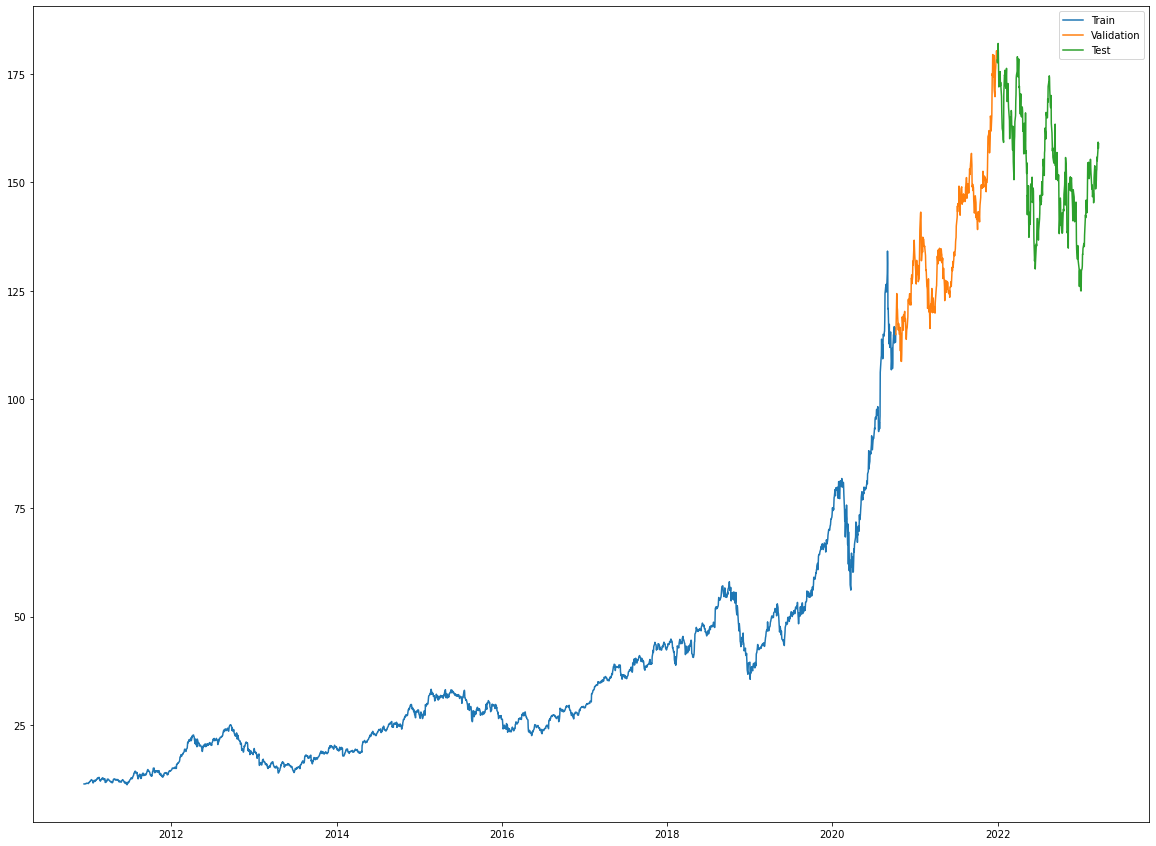

In [130]:
# split data into train, validation, and testing parititions

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['toolbar'] = 'toolmanager' 
plt.legend(['Train', 'Validation', 'Test'])

In [131]:
# first is the shape of the input (3 days in the past and one feature)
# LSTM layer is arbitrary value of 64, pretty big but not too big
# Dense layer of 32 similar reason as above
# Another stacked dense latyer
# activation = relu is good practice
# layers.dense(1) is 
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

# to compile model we set loss function
# mse is what is being minimized
# optimizer is the Adam optimizer where the learning rate is 0.001 
# new metric is mean_absolute_error --> on average how much we are off by
# minimze mse
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# 100 runs through the data set
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
78/78 [==============================] - 4s 16ms/step - loss: 1171.4910 - mean_absolute_error: 26.4083 - val_loss: 11940.6553 - val_mean_absolute_error: 108.0795
Epoch 2/100
78/78 [==============================] - 0s 6ms/step - loss: 224.9459 - mean_absolute_error: 7.9457 - val_loss: 3538.0229 - val_mean_absolute_error: 57.4771
Epoch 3/100
78/78 [==============================] - 1s 8ms/step - loss: 11.1080 - mean_absolute_error: 1.1202 - val_loss: 1030.8060 - val_mean_absolute_error: 28.5353
Epoch 4/100
78/78 [==============================] - 1s 8ms/step - loss: 2.3570 - mean_absolute_error: 0.7681 - val_loss: 617.6261 - val_mean_absolute_error: 20.5256
Epoch 5/100
78/78 [==============================] - 1s 9ms/step - loss: 1.1949 - mean_absolute_error: 0.5603 - val_loss: 464.6005 - val_mean_absolute_error: 16.5840
Epoch 6/100
78/78 [==============================] - 1s 7ms/step - loss: 1.5448 - mean_absolute_error: 0.7028 - val_loss: 400.6417 - val_mean_absolute_error:

78/78 [==============================] - 1s 8ms/step - loss: 1.1775 - mean_absolute_error: 0.6835 - val_loss: 210.8212 - val_mean_absolute_error: 9.9739
Epoch 51/100
78/78 [==============================] - 1s 9ms/step - loss: 1.3580 - mean_absolute_error: 0.7762 - val_loss: 230.1720 - val_mean_absolute_error: 10.6873
Epoch 52/100
78/78 [==============================] - 1s 11ms/step - loss: 0.9689 - mean_absolute_error: 0.5747 - val_loss: 217.7363 - val_mean_absolute_error: 10.3307
Epoch 53/100
78/78 [==============================] - 0s 5ms/step - loss: 1.0627 - mean_absolute_error: 0.6031 - val_loss: 249.7437 - val_mean_absolute_error: 11.5133
Epoch 54/100
78/78 [==============================] - 1s 11ms/step - loss: 1.0381 - mean_absolute_error: 0.6053 - val_loss: 211.1210 - val_mean_absolute_error: 9.9292
Epoch 55/100
78/78 [==============================] - 1s 9ms/step - loss: 1.1850 - mean_absolute_error: 0.6963 - val_loss: 225.6455 - val_mean_absolute_error: 10.4143
Epoch 56/10

78/78 [==============================] - 0s 4ms/step - loss: 1.0040 - mean_absolute_error: 0.6113 - val_loss: 169.0740 - val_mean_absolute_error: 8.6603
Epoch 100/100
78/78 [==============================] - 0s 4ms/step - loss: 0.9680 - mean_absolute_error: 0.5885 - val_loss: 171.3430 - val_mean_absolute_error: 8.7374


78/78 [==============================] - 1s 2ms/step


Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


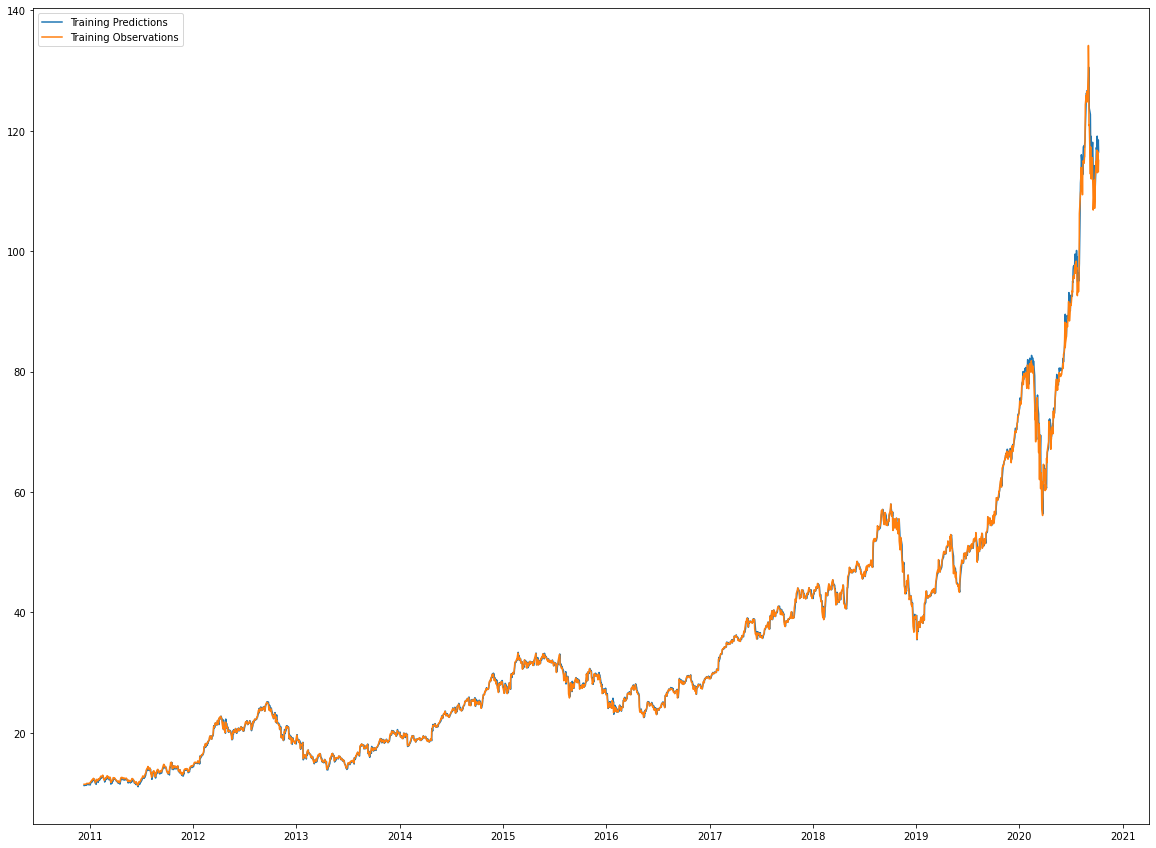

In [133]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['toolbar'] = 'toolmanager' 
plt.legend(['Training Predictions', 'Training Observations'])

# orange is actual observed values from 2021 to 2023
# blue is what we predicted --> each time it got three previous and tried
# to predict the next price

10/10 [==============================] - 0s 3ms/step


Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


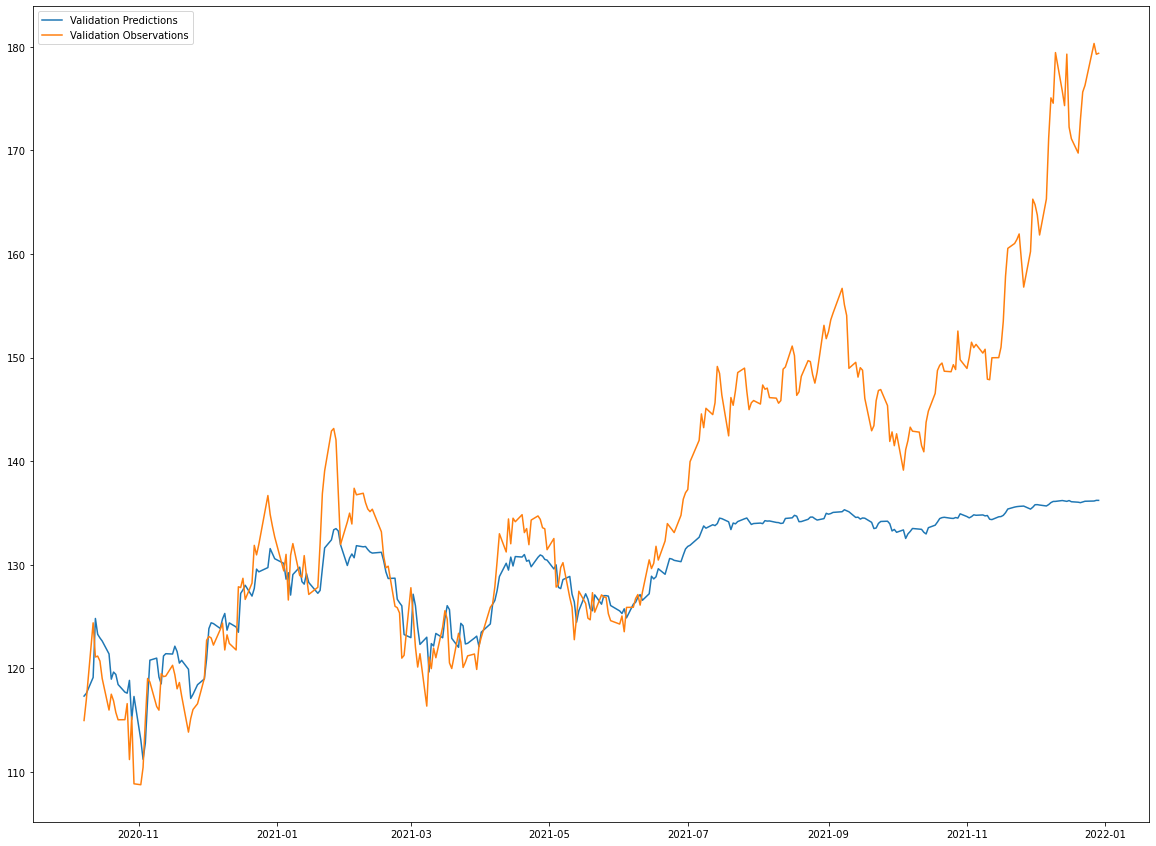

In [134]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['toolbar'] = 'toolmanager' 
plt.legend(['Validation Predictions', 'Validation Observations'])

10/10 [==============================] - 0s 3ms/step


Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


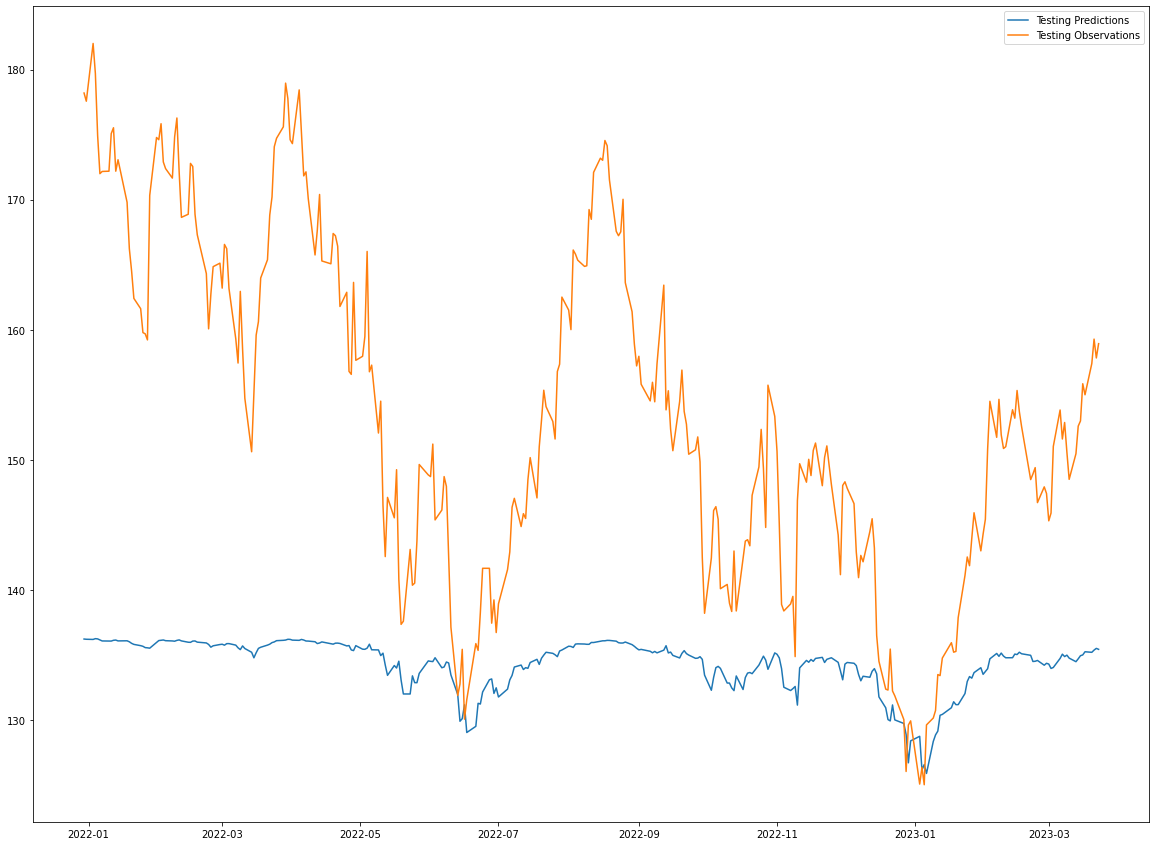

In [135]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['toolbar'] = 'toolmanager' 
plt.legend(['Testing Predictions', 'Testing Observations'])

Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


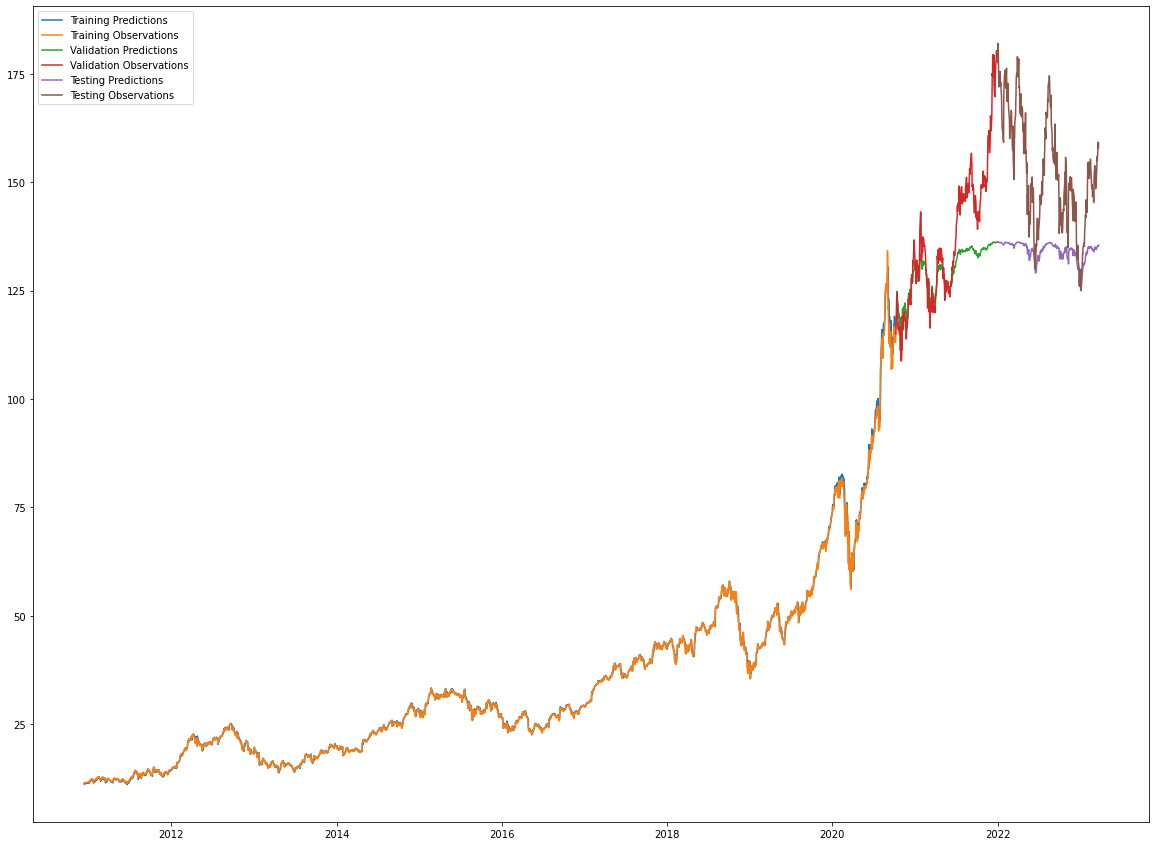

In [136]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['toolbar'] = 'toolmanager' 
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [137]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 23ms/step


Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


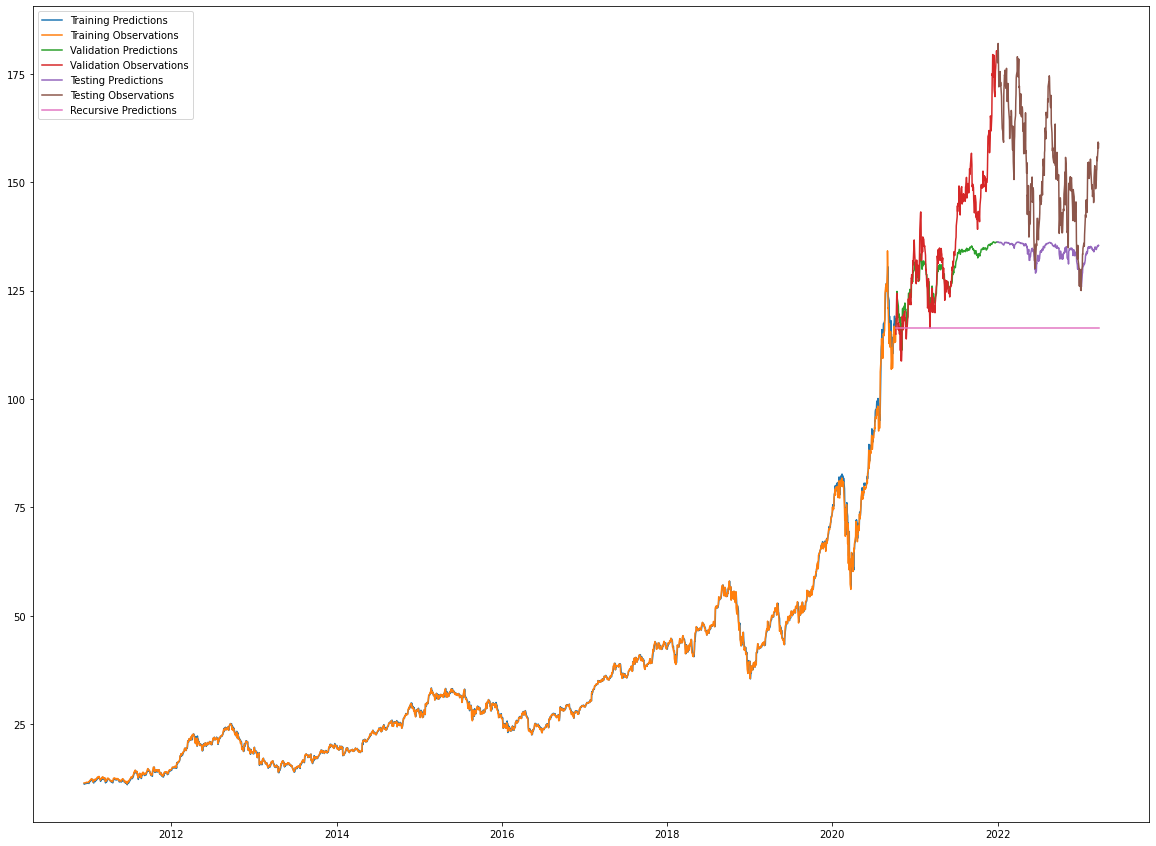

In [138]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['toolbar'] = 'toolmanager' 
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])